<a href="https://colab.research.google.com/github/mussb00/Twitter-Hate-Speech-Detector/blob/main/hate_speech_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 11.3 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive') #google drive mounted into /content/drive dir. everything held in here

Mounted at /content/drive


In [4]:
import os
directory=os.chdir('/content/drive/MyDrive/')

In [5]:
import numpy as np
import pandas as pd
import torch
import re
from transformers import (DistilBertTokenizerFast, DistilBertForSequenceClassification,
                  RobertaTokenizerFast, RobertaForSequenceClassification, Trainer, TrainingArguments,
                  EarlyStoppingCallback)
from sklearn.model_selection import train_test_split

In [6]:
df=pd.read_csv('./twitter-hatespeech/data/train_E6oV3lV.csv')
train, validation, test = np.split(df, [int(.8*len(df)), int(.9*len(df))])

In [7]:
# remove id
train.drop('id', axis=1,inplace=True)
validation.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

In [8]:
pos_samples=len(train[train['label']==1])
neg_samples=len(train[train['label']==0])
imbalance=neg_samples/pos_samples
print(imbalance)

13.220800889877642


In [9]:
train_labels=train['label'].tolist()
train_tweets=train['tweet'].tolist()

validation_labels=validation['label'].tolist()
validation_tweets=validation['tweet'].tolist()

test_labels=test['label'].tolist()
test_tweets=test['tweet'].tolist()

## Clean tweets with regex and tokenize

In [ ]:
def clean_tweet(string):

  stopping_words=["for", "on", "an", "a", "of", "and", "in", "the", "to", "from"]
  if type(string)==float:
    return ""
  
  string = string.lower()
  emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" # emoticons
                           u"\U0001F300-\U0001F5FF" # symbols & pictographs
                           u"\U0001F680-\U0001F6FF" # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE )
  
  string= emoji_pattern.sub(r'', string)
  string=re.sub("'", "", string) # to avoid removing contractions in english
  string=re.sub("@[A-Za-z0-9_]+"," ", string) # remove mentions
  string=re.sub("#[A-Za-z0-9_]+"," ", string) # remove hashtags
  string=re.sub('[()!?]'," ", string) # remove punctations
  string=re.sub('\[.*?\]'," ", string) 
  string=re.sub("[^a-z0-9]"," ", string) # remove alphanumerics
  words = string.split() # tokenisation
  without_stopping = [w for w in words if w not in stopping_words]
  cleaned_tweet = " ".join(without_stopping)

  return without_stopping

In [ ]:
train_reg = train.copy()

In [ ]:
train_reg['cleaned_tweet']=train_reg['tweet'].apply(clean_tweet)

In [ ]:
train_reg['cleaned_tweet'][1]

['thanks',
 'credit',
 'i',
 'cant',
 'use',
 'cause',
 'they',
 'dont',
 'offer',
 'wheelchair',
 'vans',
 'pdx']

## Word2Vec

- a word embedding that vectorises words such that their similarity measure (inner product) will be higher for more similar words. It is pretrained on a large corpus of text before being trained our data to (a form of transfer learning). 

In [ ]:
import gensim
from gensim.models import Word2Vec

train_w2v=train_reg.copy()
model = Word2Vec(train_w2v['cleaned_tweet'], size=100) # vector embedding of length 100 for each word

In [ ]:
print("cosine similarity between 'cause' and 'effect' is", model.wv.similarity('cause', 'effect'))

cosine similarity between 'cause' and 'effect' is 0.8920637


In [ ]:
model['cause'].shape

<ipython-input-114-5cba704e36b6>:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  model['cause'].shape


(100,)

## RoBERTa Model

In [13]:
tokenizer=RobertaTokenizerFast.from_pretrained('roberta-base')

- once words are tokenized we form matrices with each column being a vector (embedding) for a token in the sentence
- since the lengths of sentences in the corpus will differ, we pad shorter sentences/truncate longer sentences so all matrices have the same dimensions

In [14]:
# encoding + padding and truncation of data
train_robert_encodings = tokenizer(train_tweets, padding="max_length", truncation=True)
val_robert_encodings = tokenizer(validation_tweets, padding="max_length", truncation=True)
test_robert_encodings = tokenizer(test_tweets, padding="max_length", truncation=True)

In [15]:
class twitterDataSet(torch.utils.data.Dataset):
  def __init__(self, encodings, labels):
    self.encodings=encodings 
    self.labels=labels
  
  def __getitem__(self, idx):
    item={key: torch.tensor(val[idx]) for key,val in self.encodings.items()}
    item['labels']=torch.tensor(self.labels[idx])
    return item # item columns are key, encoding, label

  def __len__(self):
    return len(self.labels)


In [16]:
train_dataset=twitterDataSet(train_robert_encodings, train_labels)
val_dataset=twitterDataSet(val_robert_encodings, validation_labels)
test_dataset=twitterDataSet(test_robert_encodings, test_labels)

## Loading the model from the checkpoint

In [ ]:
# from_pretrained loads the model weights, num_labels indicates binary classification problem
# need to train the model on our data to fine tune the weights for our task
# bert_model=DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")
# robert_model=RobertaForSequenceClassification.from_pretrained("roberta-base")
robert_model=RobertaForSequenceClassification.from_pretrained('./twitter-hatespeech/roberta/results-weighted-loss/checkpoint-3000')

## Enable GPU if available

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
robert_model.to(device) # connecting model to gpu

NameError: ignored

In [ ]:
next(robert_model.parameters()).is_cuda # model loaded in cuda

True

These articles (https://medium.com/gumgum-tech/handling-class-imbalance-by-introducing-sample-weighting-in-the-loss-function-3bdebd8203b4 and https://towardsdatascience.com/handling-class-imbalanced-data-using-a-loss-specifically-made-for-it-6e58fd65ffab) outlines different weighting methods to deal with data imbalances. Since the imbalance is moderate ~10, inverse weighting is sufficient

In [ ]:
# inverse num of samples weighting scheme

def get_weights_inverse_num_of_samples(no_of_classes, samples_per_cls, power=1):
  weights_for_samples=1.0/np.array(np.power(samples_per_cls, power))
  weights_for_samples=weights_for_samples/np.sum(weights_for_samples) * no_of_classes # normalise sample weights over different classes
  return weights_for_samples

The lines of code below normalizes these sample weights across a batch of samples

In [ ]:
no_of_classes=2
batch_size=16

# weights for each class
b_labels=torch.cuda.FloatTensor(batch_size, no_of_classes) # torch.tensor of size [batch_size, no_of_classes]
# b_labels.to(device)
weights_for_samples=get_weights_inverse_num_of_samples(no_of_classes, [neg_samples, pos_samples], power=0.5)
weights_for_samples=torch.cuda.FloatTensor(weights_for_samples)
# weights_for_samples=weights_for_samples.unsqueeze(0)
# weights_for_samples=weights_for_samples.repeat(b_labels.shape[0],1)*b_labels
# weights_for_samples=weights_for_samples.sum(1)
# weights_for_samples=weights_for_samples.unsqueeze(1)
# weights_for_samples=weights_for_samples.repeat(1,no_of_classes)

In [ ]:
torch.cuda.is_available()

True

In [ ]:
weights_for_samples

tensor([0.4314, 1.5686], device='cuda:0')

In [ ]:
b_labels.is_cuda

True

In [ ]:
# weighted updates
class CustomTrainer(Trainer):
  def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs) 

  def compute_loss(self, model, inputs, return_outputs=False):
    labels=inputs.pop("labels")
    #forward pass
    outputs=model(**inputs)
    logits=outputs.logits
    # compute custom weighted loss
    loss_fct = torch.nn.CrossEntropyLoss(weight=weights_for_samples)
    loss = loss_fct(logits, labels)
    return (loss, outputs) if return_outputs else loss

no callbacks since eval_strat is 'steps' so might end before finishing an entire epoch. this would meant the model is not being trained on the entire datase.https://discuss.huggingface.co/t/early-stopping-patience-param-in-earlystoppingcallback/17762
)


In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./twitter-hatespeech/roberta/results-weighted-loss',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01, # regularisation
    logging_dir='./twitter-hatespeech/roberta/logs-weighted-loss',
    logging_steps=40, 
    evaluation_strategy="steps",
    eval_steps=50,
    report_to="all",
    metric_for_best_model = 'eval_loss',
    load_best_model_at_end = True,
    greater_is_better=False
)

trainer = CustomTrainer(
    model=robert_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,  #evaluation   
)


In [ ]:
trainer.train(resume_from_checkpoint=True)

Loading model from ./twitter-hatespeech/roberta/results-weighted-loss/checkpoint-3000.
***** Running training *****
  Num examples = 25569
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 4797
  Number of trainable parameters = 124647170
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 1
  Continuing training from global step 3000
  Will skip the first 1 epochs then the first 1401 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


  0%|          | 0/1401 [00:00<?, ?it/s]

Step,Training Loss,Validation Loss
3050,0.135600,0.169649
3100,0.075400,0.240823
3150,0.178800,0.163260
3200,0.058900,0.267151
3250,0.180800,0.314958
3300,0.123700,0.220799
3350,0.127200,0.185631
3400,0.148200,0.233415
3450,0.148900,0.226275
3500,0.150400,0.226942


***** Running Evaluation *****
  Num examples = 3196
  Batch size = 64
***** Running Evaluation *****
  Num examples = 3196
  Batch size = 64
***** Running Evaluation *****
  Num examples = 3196
  Batch size = 64
***** Running Evaluation *****
  Num examples = 3196
  Batch size = 64
***** Running Evaluation *****
  Num examples = 3196
  Batch size = 64
***** Running Evaluation *****
  Num examples = 3196
  Batch size = 64
***** Running Evaluation *****
  Num examples = 3196
  Batch size = 64
***** Running Evaluation *****
  Num examples = 3196
  Batch size = 64
***** Running Evaluation *****
  Num examples = 3196
  Batch size = 64
***** Running Evaluation *****
  Num examples = 3196
  Batch size = 64
Saving model checkpoint to ./twitter-hatespeech/roberta/results-weighted-loss/checkpoint-3500
Configuration saved in ./twitter-hatespeech/roberta/results-weighted-loss/checkpoint-3500/config.json
Model weights saved in ./twitter-hatespeech/roberta/results-weighted-loss/checkpoint-3500/pyto

TrainOutput(global_step=4797, training_loss=0.13047091812299197, metrics={'train_runtime': 6428.3298, 'train_samples_per_second': 11.933, 'train_steps_per_second': 0.746, 'total_flos': 2.039715834467328e+16, 'train_loss': 0.13047091812299197, 'epoch': 3.0})

In [ ]:
# add a few fancy plots of training against epoch or steps
trainer.save_model() # saves to output_dir

Saving model checkpoint to ./twitter-hatespeech/roberta/results-weighted-loss
Configuration saved in ./twitter-hatespeech/roberta/results-weighted-loss/config.json
Model weights saved in ./twitter-hatespeech/roberta/results-weighted-loss/pytorch_model.bin


In [17]:
model=RobertaForSequenceClassification.from_pretrained('./twitter-hatespeech/roberta/results-weighted-loss')

https://stackoverflow.com/questions/57798033/valueerror-target-size-torch-size16-must-be-the-same-as-input-size-torch

https://discuss.huggingface.co/t/specify-loss-for-trainer-trainingarguments/10481/4

## Inference

In [18]:
def to_check_result(test_encoding):
  input_ids=torch.tensor(test_encoding["input_ids"]) # transfer array to gpu
  attention_mask = torch.tensor(test_encoding["attention_mask"])
  # freeze model weights/no grad calculation
  with torch.no_grad():
    # add dimension to tensor and input into model
    outputs=model(input_ids.unsqueeze(0), attention_mask.unsqueeze(0))
  y = np.argmax(outputs[0].to('cpu').numpy())

  return y

In [19]:
# create encodings for test tweets and evaluater
l2=[]
for i in test['tweet']:

  test_encoding=tokenizer(i, truncation=True, padding=True)
  op=to_check_result(test_encoding)
  l2.append(op)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2969
           1       0.85      0.83      0.84       228

    accuracy                           0.98      3197
   macro avg       0.92      0.91      0.91      3197
weighted avg       0.98      0.98      0.98      3197



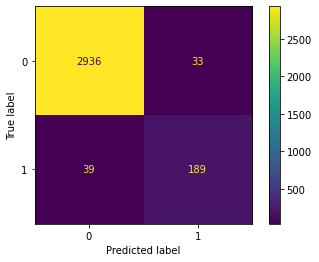

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt

confusion_matrix=confusion_matrix(test['label'], l2)
cm_display=ConfusionMatrixDisplay(confusion_matrix, display_labels=None)
print(classification_report(test['label'], l2))

cm_display.plot()
plt.show()

Recall: what proportion of the positive class (hate speech) did we correctly identify

Precison: of the things we identified as positive, how many were actual positive

In [ ]:
precision=precision_score(test_labels, l2)
recall=recall_score(test_labels, l2)
f1_score=f1_score(test_labels, l2)

In [ ]:
print(f"precision is {precision}")
print(f"recall is {recall}")
print(f"f1_score is {f1_score}")

precision is 0.8513513513513513
recall is 0.8289473684210527
f1_score is 0.8400000000000001
